# Section 1: E2C Training

This is an interactive workflow for E2C training. Note that this specific case may generate results that are distinct from the paper.

During the training process (while the last cell is running), you can monitor the training status with Tensorboard. Make sure `tensorboard` is installed properly. To install `tensorboard`:  
`pip install tensorboard`  

All the data used for `tensorboard` are stored in `logs/` directory. If you do not have `logs/` directory in your cloned repo, please create one. To turn on `tensorboard`:  
`tensorboard --logdir=logs --port=5678` (`--port` is necesary for port-forwarding)




Zhaoyang Larry Jin  
Stanford University  
zjin@stanford.edu

### Step 1. Load libaraies and config hardware (gpu)

In [1]:
import numpy as np
import h5py

import e2c as e2c_util

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1", "2", "3"

# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="3"

# GPU memory management
import tensorflow as tf
from datetime import datetime


from train import *

In [2]:
tf.__version__

'2.5.0'

In [3]:
# # tf.session specification
# # TensorFlow wizardry
# config = tf.ConfigProto()

# # Don't pre-allocate memory; allocate as-needed
# config.gpu_options.allow_growth = True

# # Only allow a total of half the GPU memory to be allocated
# config.gpu_options.per_process_gpu_memory_fraction = 0.75

# # Create a session with the above options specified.
# K.tensorflow_backend.set_session(tf.Session(config=config))

## Step 2. Specify params and load data

In [4]:
################### case specification ######################

data_dir = '../data/'
output_dir = './saved_models/'

case_name = '9w_ms_bhp_rate'
case_suffix = '_fix_wl_rel_8'
train_suffix = '_with_p'
model_suffix = '_flux_loss'

n_train_run = 300
n_eval_run = 100
num_t = 20 
dt = 100
n_train_step = n_train_run * num_t
n_eval_step = n_eval_run * num_t


train_file = case_name + '_e2c_train' + case_suffix + train_suffix + '_n%d_dt%dday_nt%d_nrun%d.mat' %(n_train_step, dt, num_t, n_train_run)
eval_file = case_name + '_e2c_eval' + case_suffix + train_suffix +'_n%d_dt%dday_nt%d_nrun%d.mat' %(n_eval_step, dt, num_t, n_eval_run)

In [5]:
#################### model specification ##################
epoch = 10
batch_size = 4
learning_rate = 1e-4
latent_dim = 50

u_dim = 9*2 # control dimension, gaussian 9 wells

# load data
hf_r = h5py.File(data_dir + train_file, 'r')
state_t_train = np.array(hf_r.get('state_t'))
state_t1_train = np.array(hf_r.get('state_t1'))
bhp_train = np.array(hf_r.get('bhp'))
dt_train = np.array(hf_r.get('dt'))
hf_r.close()

num_train = state_t_train.shape[0]
# dt_train = np.ones((num_train,1)) # dt=20days, normalized to 1

hf_r = h5py.File(data_dir + eval_file, 'r')
state_t_eval = np.array(hf_r.get('state_t'))
state_t1_eval = np.array(hf_r.get('state_t1'))
bhp_eval = np.array(hf_r.get('bhp'))
dt_eval = np.array(hf_r.get('dt'))
hf_r.close()

print("state_t_eval.shape: ", state_t_eval.shape)
print("state_t1_eval.shape: ", state_t1_eval.shape)
print("bhp_eval.shape: ", bhp_eval.shape)
print("dt_eval.shape: ", dt_eval.shape)


num_eval = state_t_eval.shape[0]
# dt_eval = np.ones((num_eval, 1)) # dt=20days, normalized to 1

state_t_eval.shape:  (2000, 60, 60, 2)
state_t1_eval.shape:  (2000, 60, 60, 2)
bhp_eval.shape:  (2000, 18)
dt_eval.shape:  (2000, 1)


In [6]:
num_batch = int(num_train/batch_size)

#### Load permeability data

In [7]:
m = np.loadtxt("../data/template/logk1.dat") # Gaussian

m = m.reshape(60, 60, 1)
print('m shape is ', m.shape)

m_tf = Input(shape=(60, 60, 1))

m_eval = np.repeat(np.expand_dims(m, axis = 0), state_t_eval.shape[0], axis = 0)
print("m_eval shape is ", m_eval.shape)

m = np.repeat(np.expand_dims(m,axis = 0), state_t_train.shape[0], axis = 0)
print("m shape is ", m.shape)

m shape is  (60, 60, 1)
m_eval shape is  (2000, 60, 60, 1)
m shape is  (6000, 60, 60, 1)


#### Load well location data

In [8]:
well_loc_file = '../data/template/well_loc00.dat'

well_loc = np.loadtxt(well_loc_file).astype(int)
num_prod = well_loc[0,0]
num_inj = well_loc[0,1]
num_well = num_prod+num_inj
print(num_inj, num_prod)

prod_loc = well_loc[1:num_prod+1,:]
print("prod_loc:\n{}".format(prod_loc))
print(prod_loc.shape)

print('prod_loc shape is ', prod_loc.shape)
# prod_loc_tf = tf.placeholder(tf.int32, shape=(num_prod,2))


4 5
prod_loc:
[[10 10]
 [ 8 52]
 [30 30]
 [50 10]
 [50 50]]
(5, 2)
prod_loc shape is  (5, 2)


In [9]:
input_shape = (60, 60, 2)
perm_shape = (60, 60, 1)
prod_loc_shape = (5, 2)

## Step 3. Construct E2C model and loss function

In [10]:
class E2C(Model):
    def __init__(self, latent_dim, u_dim, input_shape, perm_shape, prod_loc_shape, sigma=0.0):
        super(E2C, self).__init__()
        self._build_model(latent_dim, u_dim, input_shape, sigma)
        self.perm_shape = perm_shape
        self.prod_loc_shape = prod_loc_shape
    
    def _build_model(self, latent_dim, u_dim, input_shape, sigma):
        self.encoder, self.decoder, self.transition = create_e2c(latent_dim, u_dim, input_shape, sigma)
    
    def call(self, inputs):
        self.xt, self.ut, self.dt, self.perm, self.prod_loc = inputs
        
        self.zt = self.encoder(self.xt)
        self.xt_rec = self.decoder(self.zt)
        self.zt1_pred = self.transition([self.zt, self.ut, self.dt])
        self.xt1_pred = self.decoder(self.zt1_pred)
        return self.xt1_pred, self.zt1_pred, self.zt, self.xt_rec, self.perm, self.prod_loc
    
    def getLosses(self, inputs):
        pass

In [11]:
from tensorflow.keras.losses import Loss

In [12]:
class CustomizedLoss(Loss):
    def __init__(self):
        super(CustomizedLoss, self).__init__()
        self.flux_loss_lambda = 1/1000.
        self.bhp_loss_lambda = 20
        self.trans_loss_weight = 1. # lambda in E2C paper Eq. (11)
    
    def call(self, xt1, y_pred):
        # Parse y_pred
        xt1_pred, zt1_pred, zt1, zt, xt_rec, xt, perm, prod_loc = y_pred
        
        xt = tf.cast(xt, tf.float32)
        xt1 = tf.cast(xt1, tf.float32)
        
        loss_rec_t = reconstruction_loss(xt, xt_rec)
        loss_rec_t1 = reconstruction_loss(xt1, xt1_pred)

        loss_flux_t = get_flux_loss(perm, xt, xt_rec) * self.flux_loss_lambda
        loss_flux_t1 = get_flux_loss(perm, xt1, xt1_pred) * self.flux_loss_lambda

        loss_prod_bhp_t = get_well_bhp_loss(xt, xt_rec, prod_loc) * self.bhp_loss_lambda
        loss_prod_bhp_t1 = get_well_bhp_loss(xt1, xt1_pred, prod_loc) * self.bhp_loss_lambda

        loss_l2_reg = l2_reg_loss(zt)  # log(1.) = 0.

        loss_bound = loss_rec_t + loss_rec_t1 + \
                     loss_l2_reg  + \
                     loss_flux_t + loss_flux_t1 + \
                     loss_prod_bhp_t + loss_prod_bhp_t1 # JPSE 2020 Gaussian case
        
        # Use zt_logvar to approximate zt1_logvar_pred
        loss_trans = l2_reg_loss(zt1_pred - zt1)
        loss = loss_bound + self.trans_loss_weight * loss_trans
        return loss

In [13]:
class ROMWithE2C():
    def __init__(self, latent_dim, u_dim, input_shape, perm_shape, prod_loc_shape, learning_rate, sigma=0.0):
        self.model = E2C(latent_dim, u_dim, input_shape, perm_shape, prod_loc_shape, sigma)
        self.loss_object = CustomizedLoss()
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.test_loss = tf.keras.metrics.Mean(name='test_loss')
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
    def predict(self, inputs):
        xt1_pred, zt1_pred, zt, xt_rec, perm, prod_loc = self.model(inputs)
        return  xt1_pred
    
    @tf.function
    def evaluate(self, inputs, labels):
        xt1 = labels # y_true
        xt, ut, dt, _, _ = inputs
        
        predictions = self.model(inputs)
        # Parse predictions
        xt1_pred, zt1_pred, zt, xt_rec, perm, prod_loc = predictions
        zt1 = self.model.encoder(xt1)
        y_pred = (xt1_pred, zt1_pred, zt1, zt, xt_rec, xt, perm, prod_loc)
        t_loss = self.loss_object(xt1, y_pred)

        self.test_loss(t_loss)
    
    @tf.function
    def update(self, inputs, labels):
        xt1 = labels # y_true
        xt, ut, dt, _, _ = inputs
        
        with tf.GradientTape() as tape:
            predictions = self.model(inputs)
            # Parse predictions
            xt1_pred, zt1_pred, zt, xt_rec, perm, prod_loc = predictions
            zt1 = self.model.encoder(xt1)
            y_pred = (xt1_pred, zt1_pred, zt1, zt, xt_rec, xt, perm, prod_loc)
            loss = self.loss_object(xt1, y_pred)
            
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.train_loss(loss)

In [14]:
## used to generate log directory
currentDT = datetime.now()
current_time = str(currentDT).replace(" ", "-")[:-10]
print(current_time)
summary_writer = tf.summary.create_file_writer('logs/' + case_name + case_suffix + '_ep' + str(epoch) + '_tr' + str(n_train_run) + '_' + current_time)

@tf.function
def write_summary(value, tag, writer, global_step):
    with writer.as_default():
        tf.summary.scalar(tag, value, step=global_step)

2021-07-03-10:52


In [15]:
my_rom = ROMWithE2C(latent_dim, 
                    u_dim, 
                    input_shape, 
                    perm_shape, 
                    prod_loc_shape, 
                    learning_rate,
                    sigma=0.0)

sigma =  0.0


## Train

In [34]:
m_batch.shape

(4, 60, 60, 1)

In [36]:
prod_loc

array([[10, 10],
       [ 8, 52],
       [30, 30],
       [50, 10],
       [50, 50]])

In [16]:
for e in range(epoch):
    for ib in range(num_batch):
        ind0 = ib * batch_size
        
        state_t_batch  = state_t_train[ind0:ind0+batch_size, ...]
        state_t1_batch = state_t1_train[ind0:ind0 + batch_size, ...]
        bhp_batch      = bhp_train[ind0:ind0 + batch_size, ...]
        m_batch        = m[ind0:ind0 + batch_size, ...]
        dt_batch       = dt_train[ind0:ind0 + batch_size, ...]
        
        inputs = (state_t_batch, bhp_batch, dt_batch, m_batch, prod_loc)
        labels = state_t1_batch
        
        my_rom.update(inputs, labels)
        
        n_itr = e * num_train + ib * batch_size + batch_size
        write_summary(my_rom.train_loss.result(), 'train/total_loss', summary_writer, n_itr) # log for tensorboard
        summary_writer.flush()
        
        if ib % 50 == 0:
            print('Epoch %d/%d, Batch %d/%d, Loss %f,' % (e+1, epoch, ib+1, num_batch, my_rom.train_loss.result()))
            test_inputs = (state_t_eval, bhp_eval, dt_eval, m_eval, prod_loc)
            test_labels = state_t1_eval
            my_rom.evaluate(test_inputs, test_labels)

            write_summary(my_rom.test_loss.result(), 'eval/total_loss', summary_writer, n_itr) # log for tensorboard
            summary_writer.flush()

    print('====================================================')
    print('\n')
    print('Epoch %d/%d, Train loss %f, Eval loss %f' % (e + 1, epoch, my_rom.train_loss.result(), my_rom.test_loss.result()))
    print('\n')
    print('====================================================')

Epoch 1/10, Batch 1/1500, Loss 16137.257812,
Epoch 1/10, Batch 51/1500, Loss 5799.240723,
Epoch 1/10, Batch 101/1500, Loss 3373.605225,
Epoch 1/10, Batch 151/1500, Loss 2494.276855,
Epoch 1/10, Batch 201/1500, Loss 2021.756836,
Epoch 1/10, Batch 251/1500, Loss 1725.516724,
Epoch 1/10, Batch 301/1500, Loss 1523.165527,
Epoch 1/10, Batch 351/1500, Loss 1371.578735,
Epoch 1/10, Batch 401/1500, Loss 1256.955933,
Epoch 1/10, Batch 451/1500, Loss 1163.356445,
Epoch 1/10, Batch 501/1500, Loss 1086.657104,
Epoch 1/10, Batch 551/1500, Loss 1018.115906,
Epoch 1/10, Batch 601/1500, Loss 961.242126,
Epoch 1/10, Batch 651/1500, Loss 910.171204,
Epoch 1/10, Batch 701/1500, Loss 863.838867,
Epoch 1/10, Batch 751/1500, Loss 820.559998,
Epoch 1/10, Batch 801/1500, Loss 782.257751,
Epoch 1/10, Batch 851/1500, Loss 748.333862,
Epoch 1/10, Batch 901/1500, Loss 717.171204,
Epoch 1/10, Batch 951/1500, Loss 688.601562,
Epoch 1/10, Batch 1001/1500, Loss 661.863892,
Epoch 1/10, Batch 1051/1500, Loss 637.070068

Epoch 5/10, Batch 801/1500, Loss 145.027222,
Epoch 5/10, Batch 851/1500, Loss 144.189560,
Epoch 5/10, Batch 901/1500, Loss 143.401154,
Epoch 5/10, Batch 951/1500, Loss 142.769135,
Epoch 5/10, Batch 1001/1500, Loss 142.016830,
Epoch 5/10, Batch 1051/1500, Loss 141.231308,
Epoch 5/10, Batch 1101/1500, Loss 140.448929,
Epoch 5/10, Batch 1151/1500, Loss 139.738754,
Epoch 5/10, Batch 1201/1500, Loss 139.019852,
Epoch 5/10, Batch 1251/1500, Loss 138.424042,
Epoch 5/10, Batch 1301/1500, Loss 137.726196,
Epoch 5/10, Batch 1351/1500, Loss 136.977722,
Epoch 5/10, Batch 1401/1500, Loss 136.230591,
Epoch 5/10, Batch 1451/1500, Loss 135.498474,


Epoch 5/10, Train loss 134.777344, Eval loss 212.659744


Epoch 6/10, Batch 1/1500, Loss 134.762909,
Epoch 6/10, Batch 51/1500, Loss 134.042679,
Epoch 6/10, Batch 101/1500, Loss 133.325836,
Epoch 6/10, Batch 151/1500, Loss 132.626724,
Epoch 6/10, Batch 201/1500, Loss 131.950287,
Epoch 6/10, Batch 251/1500, Loss 131.387177,
Epoch 6/10, Batch 301/1500, Loss 



Epoch 10/10, Train loss 80.111145, Eval loss 119.038918




In [18]:
my_rom.model.encoder.save_weights(output_dir + 'e2c_encoder_dt_' + case_name + case_suffix + train_suffix + model_suffix + '_nt%d_l%d_lr%.0e_ep%d.h5' \
                     % (num_train, latent_dim, learning_rate, epoch))
my_rom.model.decoder.save_weights(output_dir + 'e2c_decoder_dt_' + case_name + case_suffix + train_suffix + model_suffix + '_nt%d_l%d_lr%.0e_ep%d.h5' \
                     % (num_train, latent_dim, learning_rate, epoch))
my_rom.model.transition.save_weights(output_dir + 'e2c_transition_dt_' + case_name + case_suffix + train_suffix + model_suffix + '_nt%d_l%d_lr%.0e_ep%d.h5' \
                        % (num_train, latent_dim, learning_rate, epoch))

# Seciton 2: E2C Test (eval)

In [20]:
target_suffix = '_fix_wl_rel_8' # the dataset being evaluated here
eval_file = case_name + '_e2c_eval' + target_suffix + train_suffix + '_n%d_dt%dday_nt%d_nrun%d.mat'%(n_eval_step, dt, num_t, n_eval_run)

state_file = case_name + '_train_n_400_full'
ctrl_file = case_name + '_norm_bhps_n_400'

state_data = state_file + target_suffix + '.mat'
ctrl_data = ctrl_file + target_suffix + '.mat'

## Step 4.1 Prepare data

In [45]:
import timeit
import matplotlib.pyplot as plt

### Load ROM with E2C model (if you did not run section 1)

### Load and manipulate data

In [21]:
hf_r = h5py.File(data_dir + state_data, 'r')
sat = np.array(hf_r.get('sat'))
pres = np.array(hf_r.get('pres'))
hf_r.close()

In [22]:
hf_r = h5py.File(data_dir + ctrl_data, 'r')
bhp0 = np.array(hf_r.get('bhp'))
rate0 = np.array(hf_r.get('rate'))
hf_r.close()

In [23]:
bhp = np.concatenate((bhp0,rate0),axis=1)
print(bhp.shape)

(400, 180)


In [24]:
sat = sat.T.reshape((400, 201, 3600))
pres = pres.T.reshape((400, 201, 3600))

In [25]:
test_case0 = np.zeros((25,4))
a = np.array(range(75,400,100))[np.newaxis,:]
b = np.array(range(25))[:,np.newaxis]

test_case = (test_case0 + a + b).T.reshape(100)
test_case = np.array(test_case).astype(int)

In [52]:
m = np.loadtxt("../data/template/logk1.dat") # Gaussian
m = m.reshape(60, 60, 1)
print('perm shape is ', m.shape)

perm shape is  (60, 60, 1)


### Pick 4 representative test cases to visualize  
Note here we have 100 test cases. In the E2C sequential workflow, prediction are done for all of them. However, to keep the notebook clean and short, we will only visualize a subset of 100.

In [26]:
ind_case = np.array([10, 25, 77, 97])

In [27]:
num_case = test_case.shape[0] # 4
num_tstep = 20
sat_pred = np.zeros((num_case, num_tstep, 60, 60, 1))
pres_pred = np.zeros((num_case, num_tstep, 60, 60, 1))

num_prod = 5
num_inj = 4
num_well = num_prod + num_inj

num_all_case = 400
num_ctrl = 20

Specify timesteps, time intervals, etc.

### Reshape the input data to a proper format, so that it can be easily consumed by E2C model

In [28]:
t_steps = np.arange(0,200,200//num_tstep)

dt = 10
t_steps1 = (t_steps + dt).astype(int)

indt_del = t_steps1 - t_steps
indt_del = indt_del / max(indt_del)

tmp = np.array(range(num_tstep)) - 1
tmp1 = np.array(range(num_tstep))
tmp[0] = 0

In [29]:
bhp_b0 = bhp.reshape(num_all_case, num_well, num_ctrl)
bhp_b1 = np.repeat(bhp_b0[..., np.newaxis], num_tstep // num_ctrl, axis=3)
assert num_tstep // num_ctrl * num_ctrl == num_tstep, "no exaxt division num_step = %d, num_ctrl=%d"%(num_tstep, num_ctrl)

bhp_b2 = bhp_b1.reshape(num_all_case, num_well, num_tstep)

bhp_tt = bhp_b2[:,:, tmp]
bhp_tt1 = bhp_b2[:,:, tmp1]

bhp_tt0 = np.concatenate((bhp_tt, bhp_tt1), axis=1)
bhp_t = np.swapaxes(bhp_tt0,1,2)

bhp_seq = bhp_t[test_case, :, :]

In [30]:
sat_t_seq = sat[test_case, 0, :].reshape((num_case, 60, 60, 1)) # 4 here is the 4th timestep, t = 8
pres_t_seq = pres[test_case, 0, :].reshape((num_case, 60, 60, 1))

state_t_seq = np.concatenate((sat_t_seq, pres_t_seq),axis=3)
state_pred = np.concatenate((sat_pred, pres_pred),axis=4)

In [54]:
m_t_seq = np.repeat(np.expand_dims(m, axis = 0), state_t_seq.shape[0], axis = 0)

m_t_seq shape is  (100, 60, 60, 1)


In [57]:
prod_loc_t_seq = np.repeat(np.expand_dims(prod_loc, axis = 0), state_t_seq.shape[0], axis = 0)

### Step 4.2 E2C sequential workflow

In [33]:
num_tstep

20

In [37]:
m_eval.shape

(2000, 60, 60, 1)

In [56]:
prod_loc.shape

(5, 2)

In [65]:
start = timeit.default_timer()

for i_tstep in range(num_tstep):
    state_pred[:, i_tstep, ...] = state_t_seq.copy()
    dt_seq = np.ones((num_case,1)) * indt_del[i_tstep]
#     [_, state_t1_seq] = e2c_model.predict([state_t_seq, bhp_seq[:,i_tstep,:], dt_seq])
    inputs = (state_t_seq, bhp_seq[:,i_tstep,:], dt_seq, m_t_seq, prod_loc_t_seq)
    state_t1_seq = my_rom.model.predict(inputs)[0]
    print("state_t1_seq.shape: ", state_t1_seq.shape)
    state_t_seq = state_t1_seq.copy()

end = timeit.default_timer()

print("Time for sequential process: %f" %(end - start))

state_t1_seq.shape:  (100, 60, 60, 2)
state_t1_seq.shape:  (100, 60, 60, 2)
state_t1_seq.shape:  (100, 60, 60, 2)
state_t1_seq.shape:  (100, 60, 60, 2)
state_t1_seq.shape:  (100, 60, 60, 2)
state_t1_seq.shape:  (100, 60, 60, 2)
state_t1_seq.shape:  (100, 60, 60, 2)
state_t1_seq.shape:  (100, 60, 60, 2)
state_t1_seq.shape:  (100, 60, 60, 2)
state_t1_seq.shape:  (100, 60, 60, 2)
state_t1_seq.shape:  (100, 60, 60, 2)
state_t1_seq.shape:  (100, 60, 60, 2)
state_t1_seq.shape:  (100, 60, 60, 2)
state_t1_seq.shape:  (100, 60, 60, 2)
state_t1_seq.shape:  (100, 60, 60, 2)
state_t1_seq.shape:  (100, 60, 60, 2)
state_t1_seq.shape:  (100, 60, 60, 2)
state_t1_seq.shape:  (100, 60, 60, 2)
state_t1_seq.shape:  (100, 60, 60, 2)
state_t1_seq.shape:  (100, 60, 60, 2)
Time for sequential process: 53.293937


In [66]:
# sat_seq_true = sat[test_case[ind_case], ...]
sat_seq_true = sat[test_case, ...]
sat_seq_true = sat_seq_true[:, list(np.arange(0,200,10)), :]

# pres_seq_true = pres[test_case[ind_case], ...]
pres_seq_true = pres[test_case, ...]
pres_seq_true = pres_seq_true[:, list(np.arange(0,200,10)), :]
state_seq_true = np.zeros((len(test_case),20,3600,2))
state_seq_true[:,:,:,0] = sat_seq_true
state_seq_true[:,:,:,1] = pres_seq_true

### Step 4.3 Visualization for saturation

In [69]:
s_max = 1
s_min = 0
s_diff = s_max - s_min

In [70]:
sat_pred_plot = state_pred[:, :, :, :, 0] * s_diff + s_min
state_pred[:, :, :, :, 0] = state_pred[:, :, :, :, 0] * s_diff + s_min

Case num: 10


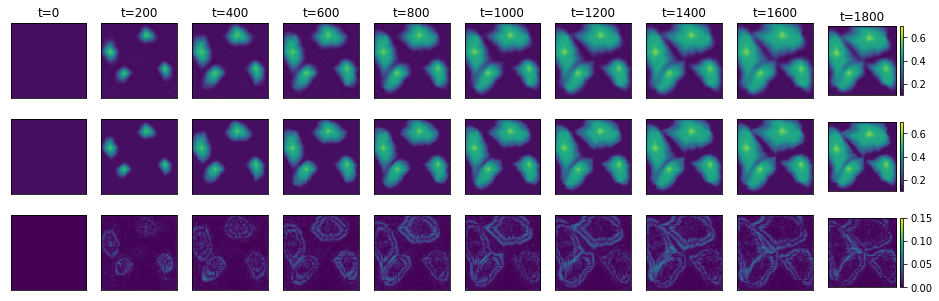

Case num: 25


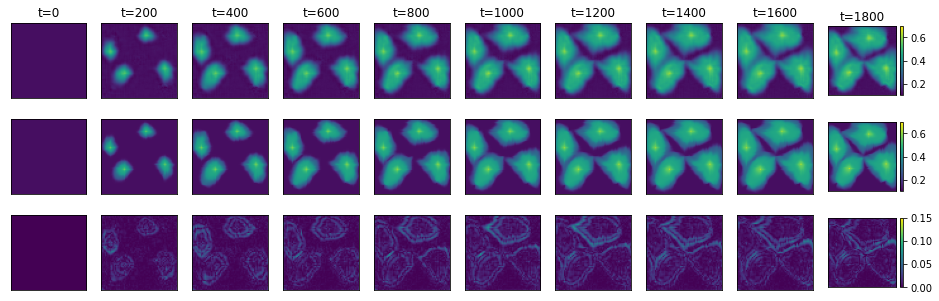

Case num: 77


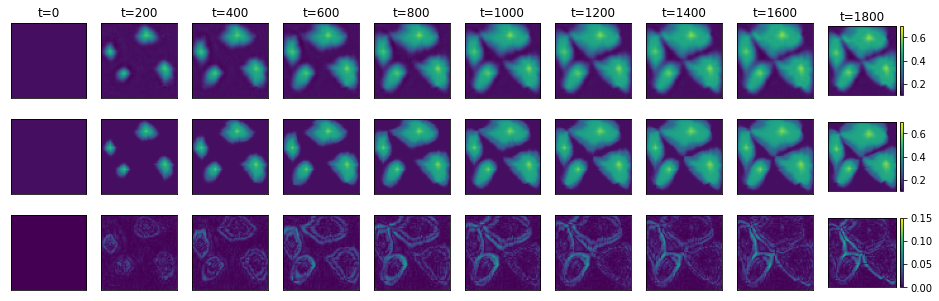

Case num: 97


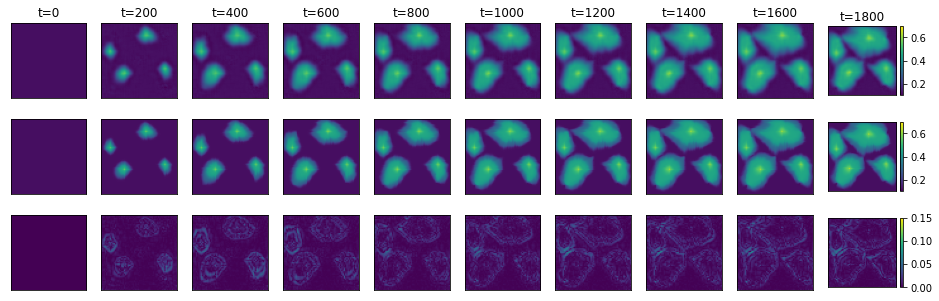

In [71]:
divide = 2
for k in range(4):
    print("Case num: %d"%ind_case[k])
    plt.figure(figsize=(16,5))
    for i_tstep in range(len(t_steps)//divide):
        plt.subplot(3, num_tstep//divide, i_tstep+1)
        plt.imshow(sat_pred_plot[ind_case[k], i_tstep*divide, :,:])
        plt.title('t=%d'%(t_steps[i_tstep*divide]*dt))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.1, 0.7])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 
            
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+num_tstep//divide)
        plt.imshow(state_seq_true[ind_case[k], i_tstep*divide, :, 0].reshape((60,60)))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.1, 0.7])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046)         
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+2*num_tstep//divide)
        plt.imshow(np.fabs(state_seq_true[ind_case[k], i_tstep*divide, :, 0].reshape((60,60)) - sat_pred_plot[ind_case[k], i_tstep*divide, :,:]))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0, 0.15])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 

    plt.show()

### Step 4.4 Visualization for pressure

In [72]:
p_max = 425
p_min = 250
p_diff = p_max - p_min

In [73]:
state_pred_plot = state_pred[:, :, :, :, 1] * p_diff + p_min
state_seq_true_plot = state_seq_true[:, :, :, 1] * p_diff + p_min

Case num: 10


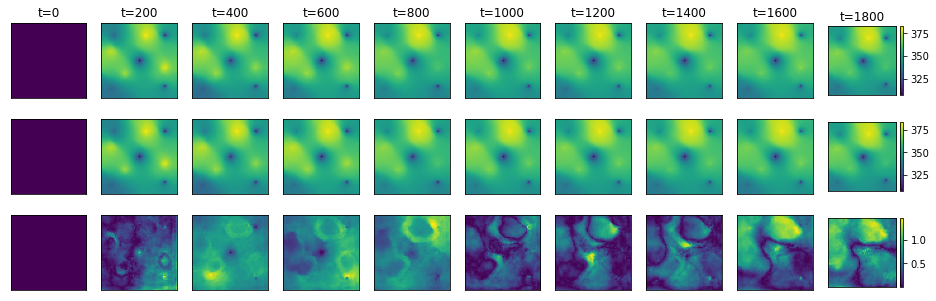

Case num: 25


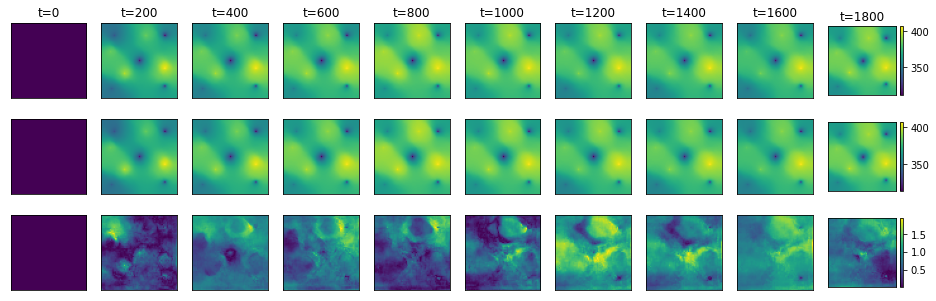

Case num: 77


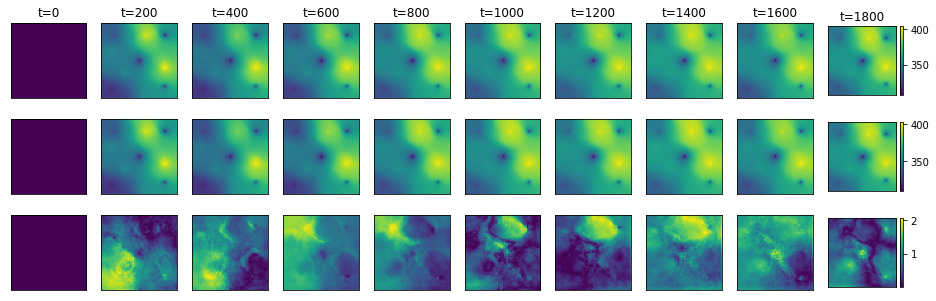

Case num: 97


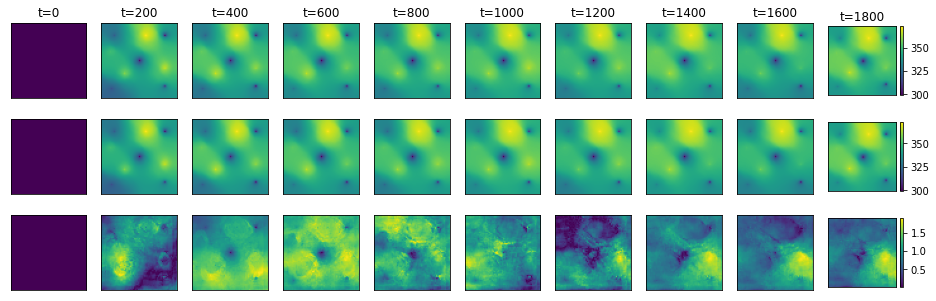

In [74]:
divide = 2
for k in range(4):
    print("Case num: %d"%ind_case[k])
    plt.figure(figsize=(16,5))
    for i_tstep in range(len(t_steps)//divide):
        plt.subplot(3, num_tstep//divide, i_tstep+1)
        plt.imshow(state_pred_plot[ind_case[k], i_tstep*divide, :, :])
        plt.title('t=%d'%(t_steps[i_tstep*divide]*dt))
        plt.xticks([])
        plt.yticks([])
#         plt.clim([4150, 4650])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 
            
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+num_tstep//divide)
        plt.imshow(state_seq_true_plot[ind_case[k], i_tstep*divide, :].reshape((60,60)))
        plt.xticks([])
        plt.yticks([])
#         plt.clim([4150, 4650])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046)         
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+2*num_tstep//divide)
        plt.imshow(np.fabs(state_seq_true_plot[ind_case[k], i_tstep*divide, :].reshape((60,60)) - state_pred_plot[ind_case[k], i_tstep*divide, :,:]))
        plt.xticks([])
        plt.yticks([])
#         plt.clim([0, 0.02])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 

    plt.show()

# Legacy code

In [6]:
input_shape = (60, 60, 2)

#############################################
# Note
# For E2C with AE, sigma = 0.0
# For E2C with UAE framework, sigma != 0.0, (e.g., =0.001)
#############################################
encoder, decoder, transition = create_e2c(latent_dim, u_dim, input_shape, sigma=0.0) 


xt = Input(shape=input_shape)
xt1 = Input(shape=input_shape)
ut = Input(shape=(u_dim, ))
dt = Input(shape=(1,))

zt = encoder(xt)
xt_rec = decoder(zt)

zt1 = encoder(xt1)

zt1_pred = transition([zt, ut, dt])
xt1_pred = decoder(zt1_pred)

# Compute loss
loss_rec_t = reconstruction_loss(xt, xt_rec)
loss_rec_t1 = reconstruction_loss(xt1, xt1_pred)

loss_flux_t = get_flux_loss(m_tf, xt, xt_rec) / 1000.
loss_flux_t1 = get_flux_loss(m_tf, xt1, xt1_pred) / 1000.

binary_sat_loss_t = get_binary_sat_loss(xt, xt_rec) * 1
binary_sat_loss_t1 = get_binary_sat_loss(xt1, xt1_pred) * 1

loss_prod_bhp_t = get_well_bhp_loss(xt, xt_rec, prod_loc_tf) * 20
loss_prod_bhp_t1 = get_well_bhp_loss(xt1, xt1_pred, prod_loc_tf) * 20

loss_l2_reg = l2_reg_loss(zt)  # log(1.) = 0.

loss_bound = loss_rec_t + loss_rec_t1 + loss_l2_reg  + loss_flux_t + loss_flux_t1 + loss_prod_bhp_t + loss_prod_bhp_t1 # JPSE 2020 Gaussian case

#####################################################################
# Note: you can also use other combination to construct loss function
# loss_bound = loss_rec_t + loss_rec_t1  + loss_flux_t + loss_flux_t1 + loss_prod_bhp_t + loss_prod_bhp_t1 # UAE
# loss_bound = loss_rec_t + loss_rec_t1 + loss_l2_reg # no flux/bhp loss comparison
# loss_bound = loss_rec_t + loss_rec_t1 + loss_l2_reg  + loss_flux_t + loss_flux_t1
# loss_bound = loss_rec_t + loss_rec_t1 + loss_kl + binary_sat_loss_t + binary_sat_loss_t1
#####################################################################

# Use zt_logvar to approximate zt1_logvar_pred
loss_trans = l2_reg_loss(zt1_pred - zt1)
# loss_trans = kl_normal_loss(zt1_mean_pred, zt1_logvar_pred, zt1_mean, zt1_logvar)


trans_loss_weight = 1.0 # lambda in E2C paper Eq. (11)
loss = loss_bound + trans_loss_weight * loss_trans

Instructions for updating:
Colocations handled automatically by placer.
sigma =  0.0


#### Create log for `Tensorboard`

In [7]:
def write_summary(value, tag, summary_writer, global_step):
    """Write a single summary value to tensorboard"""
    summary = tf.Summary()
    summary.value.add(tag=tag, simple_value=value)
    summary_writer.add_summary(summary, global_step)

## used to generate log directory
currentDT = datetime.now()
current_time = str(currentDT).replace(" ", "-")[:-10]
print(current_time)

summary_writer = tf.summary.FileWriter('logs/' + case_name + case_suffix + '_ep' + str(epoch) + '_tr' + str(n_train_run) + '_' + current_time)

2021-06-27-15:49


#### Construct computation graph (only necessary for `Tensorflow 1.x`)

In [8]:
# Optimization
opt = Adam(lr=learning_rate)

trainable_weights = encoder.trainable_weights + decoder.trainable_weights + transition.trainable_weights

updates = opt.get_updates(loss, trainable_weights)

iterate = K.function([xt, ut, xt1, m_tf, prod_loc_tf, dt], [loss, loss_rec_t, loss_rec_t1, loss_l2_reg, loss_trans, loss_flux_t, loss_flux_t1, loss_prod_bhp_t, loss_prod_bhp_t1], updates=updates)

eval_loss = K.function([xt, ut, xt1, m_tf, prod_loc_tf, dt], [loss])

num_batch = int(num_train/batch_size)



Instructions for updating:
Use tf.cast instead.


## Step 4. Begin training

In [9]:
for e in range(epoch):
    for ib in range(num_batch):
        ind0 = ib * batch_size
        state_t_batch  = state_t_train[ind0:ind0+batch_size, ...]
        state_t1_batch = state_t1_train[ind0:ind0 + batch_size, ...]
        bhp_batch      = bhp_train[ind0:ind0 + batch_size, ...]
        m_batch        = m[ind0:ind0 + batch_size, ...]
        dt_batch       = dt_train[ind0:ind0 + batch_size, ...]
        
        output = iterate([state_t_batch, bhp_batch, state_t1_batch, m_batch, prod_loc, dt_batch])
        
        n_itr = e * num_train + ib * batch_size + batch_size
        write_summary(output[0], 'train/total_loss', summary_writer, n_itr) # log for tensorboard
        write_summary(output[1]+output[2], 'train/sum_rec_loss', summary_writer, n_itr) # log for tensorboard
        write_summary(output[5]+output[6], 'train/sum_flux_loss', summary_writer, n_itr) # log for tensorboard
        write_summary(output[7]+output[8], 'train/sum_well_loss', summary_writer, n_itr) # log for tensorboard

        if ib % 50 == 0:
            print('Epoch %d/%d, Batch %d/%d, Loss %f, Loss rec %f, loss rec t1 %f, loss kl %f, loss_trans %f, loss flux %f, loss flux t1 %f, prod bhp loss %f, prod bhp loss t1 %f' % (e+1, epoch, ib+1, num_batch, output[0], output[1], output[2], output[3], output[4], output[5], output[6], output[7], output[8]))
            eval_loss_val = eval_loss([state_t_eval, bhp_eval, state_t1_eval, m_eval, prod_loc, dt_eval])
            write_summary(eval_loss_val[0], 'eval/total_loss', summary_writer, n_itr) # log for tensorboard
    
    print('====================================================')
    print('\n')
    print('Epoch %d/%d, Train loss %f, Eval loss %f' % (e + 1, epoch, output[0], eval_loss_val[0]))
    print('\n')
    print('====================================================')

encoder.save_weights(output_dir + 'e2c_encoder_dt_' + case_name + case_suffix + train_suffix + model_suffix + '_nt%d_l%d_lr%.0e_ep%d.h5' \
                     % (num_train, latent_dim, learning_rate, epoch))
decoder.save_weights(output_dir + 'e2c_decoder_dt_' + case_name + case_suffix + train_suffix + model_suffix + '_nt%d_l%d_lr%.0e_ep%d.h5' \
                     % (num_train, latent_dim, learning_rate, epoch))
transition.save_weights(output_dir + 'e2c_transition_dt_' + case_name + case_suffix + train_suffix + model_suffix + '_nt%d_l%d_lr%.0e_ep%d.h5' \
                        % (num_train, latent_dim, learning_rate, epoch))

Epoch 1/10, Batch 1/1500, Loss 16220.272461, Loss rec 7880.408203, loss rec t1 8096.715820, loss kl 0.259366, loss_trans 0.248122, loss flux 86.028725, loss flux t1 83.624542, prod bhp loss 36.298214, prod bhp loss t1 36.689026
Epoch 1/10, Batch 51/1500, Loss 1125.688843, Loss rec 259.068298, loss rec t1 377.385529, loss kl 29.301281, loss_trans 33.548450, loss flux 192.576126, loss flux t1 212.075531, prod bhp loss 8.666126, prod bhp loss t1 13.067511
Epoch 1/10, Batch 101/1500, Loss 681.733643, Loss rec 183.070587, loss rec t1 212.198669, loss kl 17.885870, loss_trans 14.253767, loss flux 123.230858, loss flux t1 121.469612, prod bhp loss 4.648535, prod bhp loss t1 4.975736


KeyboardInterrupt: 